## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import copy

from collections import defaultdict

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import runner
from src import gen_spectra

# Correct sequence fall off detection
We have a property in the program that lets us pass in a "truth" set. This truth set we will pull from Delong lab and will primarily be used for debugging our hybrids. The steps we need to take:
1. Load in SpectrumMill results and create a "truth" set where each entry in this json file has the form:
```json
{
    spectrum_id: {
        "sequence": str, 
        "hybrid": bool
    }
}
```
2. Run hyped search with the "truth_set" param set to the file generated in step 1
3. Load in the file created (output_dir + 'fall_off.json')
4. Run all analysis

## Constants

In [2]:
spec_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredSpec/'
db_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredNOD2.fasta'
output_dir = '/Users/zacharymcgrath/Desktop/Experiment output/fall_off/'
specmil_truth_set = '/Users/zacharymcgrath/Downloads/NOD2_E3_results.ssv'

minPep = 3
maxPep = 30
tolerance = 20
relative_abundance_filter = 0.0
precursor_tolerance = 3
peak_filter = 25
verbose = True


## 1. Load in SpectrumMill and create truth file

In [3]:
# first load in the results
specmil_results = pd.read_csv(specmil_truth_set, sep=';')
specmil_results.head(5)


,number,filename,parent_charge,score,deltaForwardReverseScore,deltaRank1Rank2Score,percent_scored_peak_intensity,totalIntensity,previous_aa,sequence,next_aa,retentionTimeMin,chromatographicPeakWidthSec,parent_m_over_z,species,entry_name
0,1,NOD2_E3.13446.13477.2,2,10.10,10.10,9.91,84.5,183000.0,(E),DPQVEQLEL,(-),48.35,26.0,535.7725,MOUSE,ins1C18
1,2,NOD2_E3.18005.18246.2,2,12.84,11.07,12.84,97.8,40000000.0,(G),DLQTLALEVA,(-),65.78,29.0,536.8007,MOUSE,ins1C3
2,3,NOD2_E3.13729.13828.2,2,12.43,6.68,7.86,90.7,2200000.0,(G),DLQTLALE,(-),49.52,22.0,451.7460,MOUSE,ins1C5
3,4,NOD2_E3.15226.15503.2,2,11.17,6.21,6.67,89.1,1740000.0,(G),DLQTLAL,(-),54.38,169.0,387.2243,MOUSE,ins1C6
4,5,NOD2_E3.21510.21510.2,2,12.54,12.54,12.54,91.3,91900.0,(G),DLQTLALLL,(D),76.92,3.0,500.3081,MOUSE,HYBRID: mouse ins1C PQVEQLELGGSPGDLQTLAL-LLDEG...


In [4]:
def get_hybrid_seq(peptide: str, protein: str) -> str:
    '''
    From a hybrid protein that looks like 
    ABCDE-FGHI
    
    and a peptide that looks like
    DEFGH
    
    extract 
    DE-FGH
    
    Inputs:
        peptide: (str) the desired subseq
        protein: (str) the full string with the hybrid character 
    Outputs:
        new peptide string
    '''
    # copy the protein
    prot_cp = copy.deepcopy(protein)
    
    # find the subseq
    peptide_idx = protein.replace('-', '').replace('(', '').replace(')', '').index(peptide)
    
    # get that stretch of prot
    add_on = len(peptide) + (1 if '-' in protein else 2)
    
    return protein[peptide_idx:peptide_idx+add_on]

In [5]:
# json to store results in
json_truth_set = {}

# go through every entry in the database, find out if its a hybrid and get the sequence, ided by the filename
for idx, row in specmil_results.iterrows():
    
    # all the ids seem to have .pkl at the end of them so add that
    key = row['filename'] + '.pkl'
    hybrid = 'HYBRID' in row['entry_name']
    
    seq = row['sequence'] if not hybrid else get_hybrid_seq(row['sequence'], row['entry_name'])
    
    json_truth_set[key] = {
        'hybrid': hybrid, 
        'sequence': seq
    }
    
full_truth_path = output_dir + 'specmil_truth_set.json'
    
json.dump(json_truth_set, open(full_truth_path, 'w'))

## 2. Run hypedsearch with the truth set

In [6]:
truth_run_params = {
    'spectra_folder': spec_file,
    'database_file': db_file,
    'output_dir': output_dir,
    'min_peptide_len': minPep,
    'max_peptide_len': maxPep,
    'tolerance': tolerance,
    'precursor_tolerance': precursor_tolerance,
    'peak_filter': peak_filter, 
    'relative_abundance_filter': relative_abundance_filter,
    'digest': 'trypsin', 
    'missed_cleavages': 2,
    'verbose': verbose,
    'DEBUG': False,
    'truth_set': full_truth_path
}

runner.run(truth_run_params)


DEV set to True. 
Tracking when correct answer falls off. 
Results are stored in a json named 'fall_off.json' in the specified output directory
File will be of the form

    {
        spectrum_id: {
            hybrid: bool, 
            truth_sequence: str, 
            fall_off_operation: str, 
        }
    }
            
Loading database...
Done
Loading spectra...
Done
On batch 1/1
On protein 280/280 [100%]
Sorting the set of protein masses...
Initializing other processors...
Done.
Creating an alignment for 1085/1086 [100%]
Finished search. Writting results to /Users/zacharymcgrath/Desktop/Experiment output/fall_off/...
Could not make an alignment for 498/1086 spectra (45%)


## 3. Load in the fall off results

In [7]:
fall_off_results = json.load(open(output_dir + 'fall_off.json'))
len(fall_off_results)

498

## 4. Run all analysis
1. Plot the number of results that fell into each category
2. Separate them by hybrid and non hybrd

### 4.1

In [8]:
# first load them into dictionaries by {type: [seq]}
typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    typed_fall_off[entry['fall_off_operation']].append((_id, entry))
    

<BarContainer object of 4 artists>

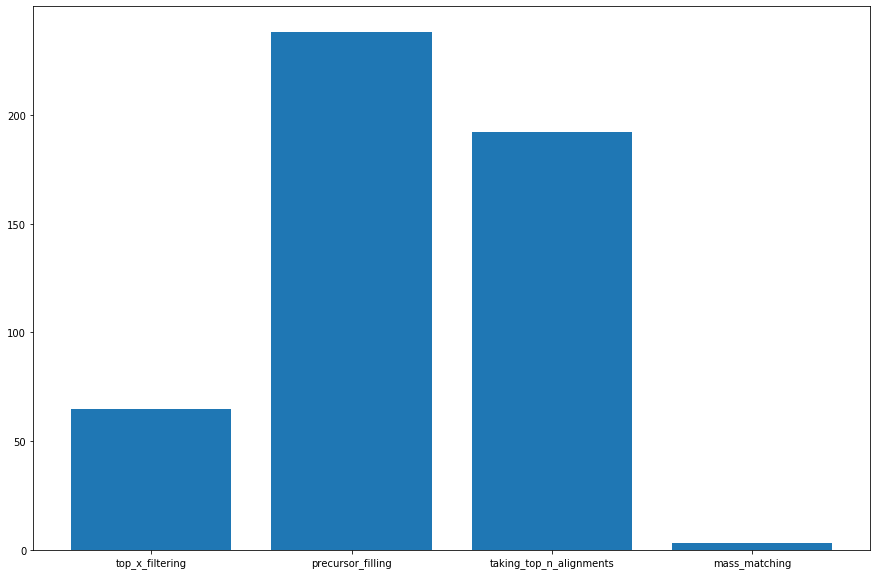

In [9]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)


### 4.2 by hybrid 

In [10]:
hybrid_typed_fall_off = defaultdict(list)
nonhybrid_typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    
    if entry['hybrid']:
        hybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))
        
    else:
        nonhybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))

Text(0.5, 1.0, 'Hybrid fall off positions')

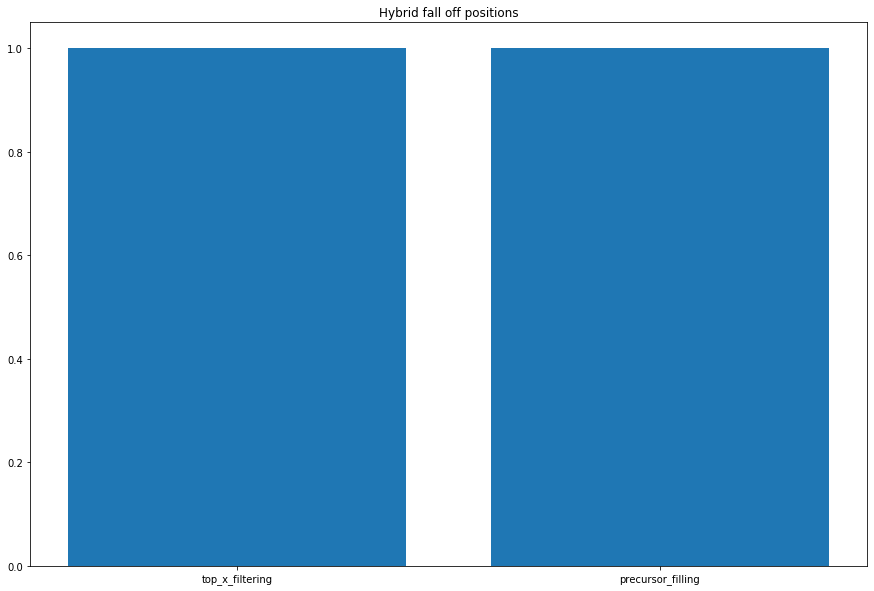

In [11]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(hybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Hybrid fall off positions')

Text(0.5, 1.0, 'Non hybrid fall off positions')

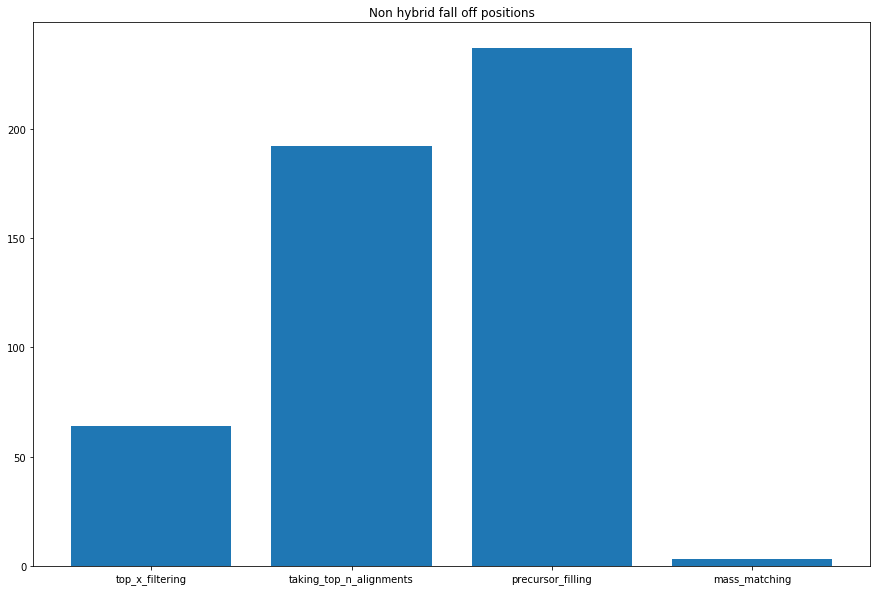

In [12]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(nonhybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Non hybrid fall off positions')

### Hybrid analysis

In [13]:
precursor_fall_offs = [x for x in hybrid_typed_fall_off['precursor_filling']]

In [14]:
for pfo in precursor_fall_offs:
    t_seq = pfo[1]['truth_sequence']
        
    print(f'Truth sequence: {t_seq}')
    print('Before\n===========================================')
    for x in pfo[1]['meta_data']['sequences_before_precursor_filling']:
        if x[0][:2] == t_seq[:2] and x[0][-2:] == t_seq[-2:]:
            print(x)
            
    print('After\n===========================================')
    for x in pfo[1]['meta_data']['sequences_after_precursor_filling']:
        if x[0][:1] == t_seq[:1] and x[0][-1:] == t_seq[-1:]:
            print(x)
            
    print()

Truth sequence: DLQTL-EVE
Before
['DLQTLINPVE', 'DLQTL-INPVE']
['DLQTLNPVE', 'DLQTL-NPVE']
['DLQTLAEPEEVE', 'DLQT(L)AEPEEVE']
['DLQTLPNVE', 'DLQTL-PNVE']
['DLQTLFRNTNVE', 'DLQTL-FRNTNVE']
['DLQTLHTLDVE', 'DLQTL-HTLDVE']
['DLQTLPQVE', 'DLQTL-PQVE']
['DLQTLGAPVE', 'DLQTL-GAPVE']
After



In [15]:
top_x_filtering = [x for x in hybrid_typed_fall_off['top_x_filtering']]

In [16]:
def is_close(truth, tried, ion, close_dist=2):
    if len(tried) > len(truth):
        return False
    
    if ion == 'b':
        return truth[:close_dist].replace('I', 'B').replace('L', 'B') == tried[:close_dist].replace('I', 'B').replace('L', 'B')
    else:
        return truth[-close_dist:].replace('I', 'B').replace('L', 'B') == tried[-close_dist:].replace('I', 'B').replace('L', 'B')
    
for _id, txf in top_x_filtering:
    t_seq = txf['truth_sequence']
    
    print(f'Truth sequence: {t_seq}')
    
    print('Kept b hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)

    print('Kept y hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print('Lost b hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)
            
    print('Lost y hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print()

Truth sequence: DLQTLAL-NAAR
Kept b hits close to correct half
DLQT
DLQDQL
Kept y hits close to correct half
Lost b hits close to correct half
DLQ
DIQ
DIQI
DLQI
DLQL
DLQNL
DIQVK
DIQVKE
Lost y hits close to correct half
ESKKAARAAR
NAAR
AARAAR
RAALAAR
EGPRCEVAAR
LCLALAWAAR



### Non hybrid analysis
As of NOV 12, it looks like precursor filling is the worst and ruining our chances. Lets look at the halves and see if we can determine why this step is ruining it

In [17]:
# get the precursor filling subjects
nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['precursor_filling']]

In [18]:
# go through every entry and find the sequences that were closest to the real sequence as possible
# closeness is: 
#   1. Having a lot of the right amino acids
#   2. Not have too many amino acids or too few
# Prioritize 1, rank by 2
def closeness(t_seq, trying, observed_precursor) -> (int, int):
    
    from_right = 0
    from_left = 0
    
    prec_distance = abs(gen_spectra.get_precursor(trying) - observed_precursor)
    
    # first check if they ARE the same
    if t_seq == trying:
        return (len(t_seq), 0, prec_distance)
    
    # go from left to right
    i = 0
    while i < len(t_seq) and i < len(trying) and t_seq[i] == trying[i]:
        i += 1
        from_left += 1
        
    # now right to left
    i = -1
    while abs(i) < len(t_seq) + 1 and abs(i) < len(trying) + 1 and t_seq[i] == trying[i]:
        i -= 1
        from_right += 1
        
    return (from_left + from_right, abs(len(t_seq) - len(trying)), prec_distance)

for _id, nhpfo in nh_precursor_fall_off:
    
    # get the real sequence
    t_seq = nhpfo['truth_sequence']
    
    # keep track of the best of the close ones 
    overlapped_idxed_close_hits = defaultdict(list)
    
    observed_prec = nhpfo['meta_data']['observed_precursor_mass']
    
    for non_hyb, hyb in nhpfo['meta_data']['sequences_before_precursor_filling']:
        overlap, dist, prec_dist = closeness(t_seq, non_hyb, observed_prec)
        overlapped_idxed_close_hits[overlap].append((non_hyb, hyb, dist, prec_dist))
        
    # now get the hightest key
    best_key = max(list(overlapped_idxed_close_hits.keys()))
    
    # show the best results sorted by their distance
    print(f'Hits with the most overlap ({best_key} AAs) for sequence {t_seq}')
    print('=====================================================================================')
    for seq, hyb_seq, dist, prec_distance in sorted(overlapped_idxed_close_hits[best_key], key=lambda x: x[2]):
        print(f'{seq} \t {dist} \t {prec_distance} \t {hyb_seq}')
        
    print()
    

Hits with the most overlap (15 AAs) for sequence DEAPNFEANTTIGRIRFH
TVPPAAPAGEGGPPAPPPNFEANTTIGRIRFH 	 14 	 2713.8965331 	 TVPPAAPAGEGGPPAPPP(N)FEANTTIGRIRFH
TVPPAAPAGEGGPPAPPPNFEANTTIGRIRFH 	 14 	 2713.8965331 	 TVPPAAPAGEGGPPAPPPN-FEANTTIGRIRFH

Hits with the most overlap (6 AAs) for sequence DVTKGRKFYGPEGPYGVFAGR
KKYESEESVSKGSWQGVFAGR 	 0 	 1783.1142721000006 	 KKYESEESVSKGSWQ-GVFAGR
KKLEAAEERRKSQEAGVFAGR 	 0 	 1784.2258981000004 	 KKLEAAEERRKSQEA-GVFAGR
KKRSLCRNAHRSSTEGVFAGR 	 0 	 1784.1942201000006 	 KKRSLCRNAHRSSTE-GVFAGR
KKSREKITAEHETTDGVFAGR 	 0 	 1784.1782801000004 	 KKSREKITAEHETTD-GVFAGR
SVVCFLNNFYPKDINGVFAGR 	 0 	 1784.1321711 	 SVVCFLNNFYPKDIN-GVFAGR
KLEAAEERRKSQEAQGVFAGR 	 0 	 1784.1895131000006 	 KLEAAEERRKSQEAQ-GVFAGR
KEVFTRFCTGLTQIEGVFAGR 	 0 	 1783.1692971000002 	 KEVFTRFCTGLTQIE-GVFAGR
VGIEADDDRLNKVISEGVFAGR 	 1 	 1784.1670451000005 	 VGIEADDDRLNKVISE-GVFAGR
GVAKMSLDPADLTHGVFAGR 	 1 	 1465.9953540999995 	 GVAKMSLDPADLTH-GVFAGR
KMEKPSLSQQAAHGVFAGR 	 2 	 1466.006587100

Hits with the most overlap (12 AAs) for sequence DTDHSGFIETEELKNFLK
TRRFIETEELKNFLK 	 3 	 1392.5516151000002 	 TRRF-IETEELKNFLK
DLKTPAGLQVLNDIETEELKNFLK 	 6 	 2196.9632811 	 DLKTPAGLQVLND-IETEELKNFLK

Hits with the most overlap (16 AAs) for sequence VEYPAHQAMNLVGPQSIEGGAHEGLQHLGPFGNIPNIVA
VEYPAHQAMNLPNIVA 	 23 	 750.6255800999995 	 VEYPAHQAMNL-PNIVA

Hits with the most overlap (4 AAs) for sequence DKDGDGTITTKELGTVMRSLGQNPTEAELQ
EAAELQ 	 24 	 141.57931889999998 	 EAAE-LQ

Hits with the most overlap (5 AAs) for sequence VEYPAHQAMNLVGPQSIEGGAHEGLQHLGPFGNIPNIVAELTG
YYEILNNPELACTLAKTAFDEAIAELTG 	 15 	 1957.1944111000003 	 YYEILNNPELACTLAKTAFDEAIAE-LTG
AEAELTG 	 36 	 425.98255789999996 	 AEAE-LTG
EAAELTG 	 36 	 425.98255789999996 	 EAAE-LTG

Hits with the most overlap (4 AAs) for sequence DEIEFLKKLHEEELR
SSEELR 	 9 	 237.59327810000008 	 SSEE-LR

Hits with the most overlap (16 AAs) for sequence DGTITTKELGTVMRSLGQNPTEAELQ
EDLKSELSSNFEQVILGLMTPTVMRSLGQNPTEAELQ 	 11 	 3406.940981099999 	 EDLKSE

Hits with the most overlap (7 AAs) for sequence DEKVLTEIIASRTPEELSAIKQVYEEEYGSNLE
AKSPEKEEAKTSEKVAPKKEYGSNLE 	 7 	 1931.006056100001 	 AKSPEKEEAKTSEKVAPKKE-YGSNLE
KKISLEDIQAFEKTYKGSEYGSNLE 	 8 	 1930.9736851000011 	 KKISLEDIQAFEKTYKGSE-YGSNLE
KAFMSQQSETSLQSIRLLEYGSNLE 	 8 	 1912.9413481000006 	 KAFMSQQSETSLQSIRLLE-YGSNLE
KAQALQEECGYLRRHHQEYGSNLE 	 9 	 1912.8811411000006 	 KAQALQEECGYLRRHHQE-YGSNLE
KKSLDSDESEDEYGSNLE 	 15 	 1098.4049760999997 	 KKSLDSDESEDE-YGSNLE
KAKAAFENWEYGSNLE 	 17 	 910.4034020999999 	 KAKAAFENWE-YGSNLE
KKEVVEEAEYGSNLE 	 18 	 777.3605340999999 	 KKEVVEEAE-YGSNLE

Hits with the most overlap (12 AAs) for sequence DDLKSELTGKFEKLIVAMMKPSRLY
GGAQGPSKDKVAVLIVAMMKPSRLY 	 0 	 2033.1163421000003 	 GGAQGPSKDKVAVL-IVAMMKPSRLY
KEPRSLSAASAPLIVAMMKPSRLY 	 1 	 2033.1163401000001 	 KEPRSLSAASAPL-IVAMMKPSRLY
SFMFQRVLVSLIVAMMKPSRLY 	 3 	 2033.1026051000001 	 SFMFQRVLVSL-IVAMMKPSRLY
AFVYHAFVFLLIVAMMKPSRLY 	 3 	 2033.1032490999999 	 AFVYHAFVFLL-IVAMMKPSRLY
KYFSELRASLIVAMMKPSRLY 	 4 	 

Hits with the most overlap (13 AAs) for sequence LEGQAAKEFIAWLVKGRGRR
LEGEAWLVKGRGRR 	 6 	 1054.8372050999997 	 LEGE-AWLVKGRGRR

Hits with the most overlap (9 AAs) for sequence DVSSYLEGQAAK
TMSYLEGQAAK 	 1 	 775.3656521 	 TMS-YLEGQAAK
DYVPKLYLEGQAAK 	 2 	 1171.6359281 	 DYVPKL(Y)LEGQAAK
DYVPKLYLEGQAAK 	 2 	 1171.6359281 	 DYVPKLY-LEGQAAK
TLDTVVSYLEGQAAK 	 3 	 1171.6206810999997 	 TLDTVVS-YLEGQAAK
DAELVKYKDQIKYLEGQAAK 	 8 	 1887.0223821000002 	 DAELVKYKDQIK-YLEGQAAK

Hits with the most overlap (13 AAs) for sequence YLEGQAAKEFIAWLVKGRGRR
YLEQIHRGVKAWLVKGRGRR 	 1 	 1809.5596870999998 	 YLEQIHRGVK-AWLVKGRGRR
YLEVLLKLADKYAWLVKGRGRR 	 1 	 2034.7100901 	 YLEVLLKLADKY-AWLVKGRGRR
YLPLIAWLVKGRGRR 	 6 	 1185.2504800999995 	 YLPLI-AWLVKGRGRR

Hits with the most overlap (15 AAs) for sequence SYLEGQAAKEFIAWLVKGRGRR
SYLEQIHRGVKIAWLVKGRGRR 	 0 	 1987.9167721 	 SYLEQIHRGVK-IAWLVKGRGRR
SYLTFIAWLVKGRGRR 	 6 	 1288.5027660999995 	 SYLTF(I)AWLVKGRGRR

Hits with the most overlap (14 AAs) for sequence SSYLEG

Hits with the most overlap (7 AAs) for sequence APSDPRLRQFLQKSLAAATGKQ
ALFTAATGKQ 	 12 	 410.96471110000005 	 ALFT-AATGKQ
AFLTAATGKQ 	 12 	 410.96471110000005 	 AFLT-AATGKQ
AFITAATGKQ 	 12 	 410.96471110000005 	 AFIT-AATGKQ
AATGKQ 	 16 	 21.27255989999992 	 None

Hits with the most overlap (16 AAs) for sequence QFLQKSLAAATGKQELAKYFLAELLSEPNQTEN
QDDAGYFLAELLSEPNQTEN 	 13 	 1333.0301501000001 	 QDDAG-YFLAELLSEPNQTEN
QPNTYFLAELLSEPNQTEN 	 14 	 1287.0610561 	 QPNT-YFLAELLSEPNQTEN
QDDQYFLAELLSEPNQTEN 	 14 	 1333.0301501000001 	 QDDQ-YFLAELLSEPNQTEN
QDQDYFLAELLSEPNQTEN 	 14 	 1333.0301501000001 	 QDQD-YFLAELLSEPNQTEN
QNPTYFLAELLSEPNQTEN 	 14 	 1287.0610561 	 QNPT-YFLAELLSEPNQTEN
EKEKYFLAELLSEPNQTEN 	 14 	 1361.1342201 	 EKEK-YFLAELLSEPNQTEN
KEEKYFLAELLSEPNQTEN 	 14 	 1361.1342201 	 KEEK-YFLAELLSEPNQTEN

Hits with the most overlap (8 AAs) for sequence APSDPRLRQFLQKSLAAATGKQ
APDLGFLRKSAATGKQ 	 6 	 1182.4466840999999 	 APDLGFLRKS(A)ATGKQ
APAPAATGKQ 	 12 	 434.02351110000006 	 APAP-AATGKQ
APPAAT

Hits with the most overlap (15 AAs) for sequence LQKSLAAATGKQELAKYFLA
LQIQCVATGKQELAKYFLA 	 1 	 1585.5915031000004 	 LQIQCV-ATGKQELAKYFLA
LQGALTMKQVNPSATGKQELAKYFLA 	 6 	 2268.951742100001 	 LQGALTMKQVNPS-ATGKQELAKYFLA

Hits with the most overlap (5 AAs) for sequence EVATGEKRATVVESSEKAYSEAH
EVESNSPAALAGLRSFPASQTEAH 	 1 	 1848.8920091000002 	 EVESNSPAALAGL-RSFPASQTEAH

Hits with the most overlap (10 AAs) for sequence DMEEEQAFKRSRNT
TYKPEQAFKRSRNT 	 0 	 1289.9474140999998 	 TYKP-EQAFKRSRNT
TLFQEQAFKRSRNT 	 0 	 1289.9474231 	 TLFQ-EQAFKRSRNT
SMSMEQAFKRSRNT 	 0 	 1236.8337141 	 SMSM-EQAFKRSRNT
SVFREQAFKRSRNT 	 0 	 1289.9586551 	 SVFR-EQAFKRSRNT
TFQIEQAFKRSRNT 	 0 	 1289.9474231 	 TFQI-EQAFKRSRNT
TQFLEQAFKRSRNT 	 0 	 1289.9474231 	 TQFL-EQAFKRSRNT
TKYPEQAFKRSRNT 	 0 	 1289.9474140999998 	 TKYP-EQAFKRSRNT
TLQFEQAFKRSRNT 	 0 	 1289.9474231 	 TLQF-EQAFKRSRNT
MDDMEQAFKRSRNT 	 0 	 1292.8235441 	 MDDM-EQAFKRSRNT
TKPYEQAFKRSRNT 	 0 	 1289.9474140999998 	 TKPY-EQAFKRSRNT
TFQLEQAFKRSRNT 	 0 	 1289.9

Hits with the most overlap (5 AAs) for sequence DGYLSLLQ
EIELSLLQ 	 0 	 489.7897271000001 	 EIEL-SLLQ
EELLSLLQ 	 0 	 489.7897271000001 	 EELL-SLLQ
ELELSLLQ 	 0 	 489.7897271000001 	 ELEL-SLLQ
YGDLSLLQ 	 0 	 453.73220410000005 	 YGDL-SLLQ
EEILSLLQ 	 0 	 489.7897271000001 	 EEIL-SLLQ
GYDLSLLQ 	 0 	 453.73220410000005 	 GYDL-SLLQ
TVLSLLQ 	 1 	 318.73657010000005 	 TVL(S)LLQ
EKMELSLLQ 	 1 	 635.8411110999998 	 EKMEL-SLLQ
ELACTLSLLQ 	 2 	 635.8411120999999 	 ELACTL-SLLQ

Hits with the most overlap (14 AAs) for sequence DKYLIANATNPESKVFYLKMKG
KKGKTLMMFVTNPESKVFYLKMKG 	 2 	 2298.6486621000004 	 KKGKTLMMFVT-NPESKVFYLKMKG
PETKAIMKWIQTNPESKVFYLKMKG 	 3 	 2460.7093480999997 	 PETKAIMKWIQT-NPESKVFYLKMKG

Hits with the most overlap (13 AAs) for sequence DELKEYESIIAIQENELKKRA
DEEDAIQENELKKRA 	 6 	 1283.2030350999999 	 DEED-AIQENELKKRA
DEDEAIQENELKKRA 	 6 	 1283.2030350999999 	 DEDE-AIQENELKKRA

Hits with the most overlap (4 AAs) for sequence DVNKSKEYFSKQ
SVQFNQLFSKQ 	 1 	 956.7434141000001 	 SVQFNQL

Hits with the most overlap (5 AAs) for sequence DMFQSKMLSKGGYPKAPGRGMVEALP
DMRLVNGACDPDAAKAIVDALP 	 4 	 1555.5087810999999 	 DMRLVNGA-CDPDAAKAIVDALP
DMRLVNGAEQSHLALP 	 10 	 1051.2833950999998 	 DMRLVNGA-EQSHLALP
DMRLVNGALP 	 16 	 385.9701060999997 	 DMRLVNGA-LP
KKNSVVEALP 	 16 	 385.02900009999996 	 KKNSVVEA-LP

Hits with the most overlap (18 AAs) for sequence DVVGGEDWSPIEEKIETQTQEEVR
DVKMVSPIEEKIETQTQEEVR 	 3 	 1794.1750871 	 DVKMV(S)PIEEKIETQTQEEVR
DVKMVSPIEEKIETQTQEEVR 	 3 	 1794.1750871 	 DVKMVS-PIEEKIETQTQEEVR
DVSKTGALEGPEVDGFVKSPIEEKIETQTQEEVR 	 10 	 3050.796563100001 	 DVSKTGALEGPEVDGFVK-SPIEEKIETQTQEEVR

Hits with the most overlap (7 AAs) for sequence DKALMRLPYGPGKSRA
KTLETVPLEGPGKSRA 	 0 	 1242.1961550999997 	 KTLETVPLE-GPGKSRA
KKAAPEETRGPGKSRA 	 0 	 1242.1822360999997 	 KKAAPEETR-GPGKSRA
KKSPNELVDGPGKSRA 	 0 	 1242.1710010999998 	 KKSPNELVD-GPGKSRA
SIAMLVQEGPGKSRA 	 1 	 1103.0786820999997 	 SIAMLVQE-GPGKSRA
APVLHPLSGPGKSRA 	 1 	 1046.1014661 	 APVLHPLS-GPGKSRA
KDVKYYTLGPGKSRA

Hits with the most overlap (9 AAs) for sequence EKIVVLLQRLKPEIK
KKQAEILQRLKPEIK 	 0 	 1460.0885821 	 KKQAEI(LQ)RLKPEIK
KEIVGTLQRLKPEIK 	 0 	 1390.0354840999996 	 KEIVGT(L)QRLKPEIK
KELIEKLQRLKPEIK 	 0 	 1503.1195470999999 	 KELIEK-LQRLKPEIK
KEIVGTLQRLKPEIK 	 0 	 1390.0354840999996 	 KEIVGTL-QRLKPEIK
KKQAEILQRLKPEIK 	 0 	 1460.0885821 	 KKQAEIL(Q)RLKPEIK
KKAVLFCLQRLKPEIK 	 1 	 1552.1334240999997 	 KKAVLFC(L)QRLKPEIK
KKAVLFCLQRLKPEIK 	 1 	 1552.1334240999997 	 KKAVLFCL-QRLKPEIK
APALVLQRLKPEIK 	 1 	 1213.9557770999998 	 APALV-LQRLKPEIK
KLEALSVLQRLKPEIK 	 1 	 1503.1195470999999 	 KLEALSV-LQRLKPEIK
KIEKELQRLKPEIK 	 1 	 1390.0354830999997 	 KIEKEL-QRLKPEIK
KELKELQRLKPEIK 	 1 	 1390.0354830999997 	 KELKEL-QRLKPEIK
KKLLYEKLQRLKPEIK 	 1 	 1665.2352370999995 	 KKLLYEK-LQRLKPEIK
KIEKELQRLKPEIK 	 1 	 1390.0354830999997 	 KIEKE(L)QRLKPEIK
KELKELQRLKPEIK 	 1 	 1390.0354830999997 	 KELKE(L)QRLKPEIK
KKLPKTELQRLKPEIK 	 1 	 1587.1882961 	 KKLPKTE-LQRLKPEIK
APAIVLQRLKPEIK 	 1 	 1213.9557770999998 	 APAIV-

DNQRILEFFGLKKEECPACREVIITP 	 15 	 2095.0750781000006 	 DNQRILEFFGLKKEECPA-CREVIITP
DNQRILEFFGLKKEECPAVTP 	 20 	 1480.7540611000002 	 DNQRILEFFGLKKEECPAV-TP
TVLGWMLQYARGLWLSRADTP 	 20 	 1480.7805431 	 TVLGWMLQYARGLWLSRAD-TP
VYGLDLHPTLDVLVTCSRDTP 	 20 	 1360.6853051 	 VYGLDLHPTLDVLVTCSRD-TP
DNQRILEFFGLKKEECPATP 	 21 	 1381.6856471000003 	 DNQRILEFFGLKKEECPA-TP
DKANMQHRYVELFLNSTATP 	 21 	 1381.6604861000003 	 DKANMQHRYVELFLNSTA-TP
ELHEPIPSLFRALTEGDTP 	 22 	 1168.5920641 	 ELHEPIPSLFRALTEGD-TP
SILCSRNRNHLLHVFDTP 	 23 	 1168.6080040999998 	 SILCSRNRNHLLHVFD-TP

Hits with the most overlap (5 AAs) for sequence DEWMRIILEALRQAENEPPSAPKENKPYALNLEKNFPVDTP
DEEDLRAFQVQQAAVLRQTAVHNGAGGALFVHRDTP 	 5 	 3122.2365161 	 DEEDLRAFQVQQAAVLRQ-TAVHNGAGGALFVHRDTP
DEDELLGKLSEEELKQLETAVHNGAGGALFVHRDTP 	 5 	 3123.2079580999994 	 DEDELLGKLSEEELKQLE-TAVHNGAGGALFVHRDTP
DEEDTAVHNGAGGALFVHRDTP 	 19 	 1513.3152700999995 	 DEED-TAVHNGAGGALFVHRDTP
DETSTAVHNGAGGALFVHRDTP 	 19 	 1457.3254410999994 	 DETS-TAVHNGAGGALFVHRDTP

Hits with the most overlap (8 AAs) for sequence DLFLHHKKNISEAELEEYTSTMMKIF
TTRILSDTSTMMKIF 	 11 	 955.5010400999997 	 TTRILSDT-STMMKIF
TVVTSTMMKIF 	 15 	 468.26197909999996 	 TVVT-STMMKIF

Hits with the most overlap (4 AAs) for sequence DTLMEENVQKVKEQLMTSHNVSKEGRILMKELASMFLSE
TDSPKAHVQFLSE 	 26 	 704.0045301 	 TDSPKAHV-QFLSE
TTIGYGDKQFLSE 	 26 	 703.9932890999999 	 TTIGYGDK-QFLSE
TVEHCIIGQFLSE 	 26 	 721.0020881 	 TVEHCIIG-QFLSE
TSPLPEEVQFLSE 	 26 	 721.0086120999999 	 TSPLPEEV-QFLSE
TDILKAPPQFLSE 	 26 	 704.0660680999999 	 TDILKAPP-QFLSE
TSGGASVVQFLSE 	 26 	 526.9143181 	 TSGGASVV-QFLSE
TSPVQDPKQFLSE 	 26 	 721.0198461 	 TSPVQDPK-QFLSE
ESTANRHGQFLSE 	 26 	 720.9695410999998 	 ESTANRHG-QFLSE
ESIHKLKQFLSE 	 27 	 704.0773000999998 	 ESIHKLK-QFLSE
TTAKADAQFLSE 	 27 	 526.9143190999998 	 TTAKADA-QFLSE
TTRSYFPQFLSE 	 27 	 720.9987080999999 	 TTRSYFP-QFLSE
TDKGGLSQFLSE 	 27 	 526.9143181 	 TDKGGLS-QFLSE
TDGKGISQFLSE 	 27 	 526.9143181 	 TDGKGIS-QFLSE
EISELSQFLSE 	 28 	 526.9030831 	 EISELS-Q

Hits with the most overlap (11 AAs) for sequence DDTFEALRIEPFSSPPELP
DSEPFSSPPELP 	 7 	 580.9007510999996 	 DSE-PFSSPPELP
DSDSEDKGEESKPKKKKEPFSSPPELP 	 8 	 2294.7904781000007 	 DSDSEDKGEESKPKKKKE-PFSSPPELP
DSSDNPAGLAEQCPGMRKRPAAEPFSSPPELP 	 13 	 2630.8844151000008 	 DSSDNPAGLAEQCPGMRKRPAAE-PFSSPPELP

Hits with the most overlap (6 AAs) for sequence DFTPENYKRIEAIVKNYPEGHQAAAVLPVL
DFFASGLPLPVL 	 18 	 598.3359720999997 	 DFFASGLPL-PVL

Hits with the most overlap (12 AAs) for sequence DFPEFLTMMSRKMK
EPPEFLTMMSRKMK 	 0 	 1283.8831791 	 EPPE-FLTMMSRKMK
PEPEFLTMMSRKMK 	 0 	 1283.8831791 	 PEPE-FLTMMSRKMK

Hits with the most overlap (11 AAs) for sequence DQLTEEQIAEFKEAF
QEEQIAEFKEAF 	 3 	 868.7390981 	 QEEQ-IAEFKEAF

Hits with the most overlap (4 AAs) for sequence DKGSSKEVEHAKIPEPTPTV
KKSQIFSTASDNQPTVTPTV 	 0 	 1611.0785811 	 KKSQIFSTASDNQPTVT-PTV
KKGDYQKAYEQNMIGMTPTV 	 0 	 1764.0856411 	 KKGDYQKAYE-QNMIGMTPTV
KKEADRESFQNMIGMTPTV 	 1 	 1644.0281420999995 	 KKEADRESF-QNMIGMTPTV
KKEMPNLFCQNMIGMTP

Hits with the most overlap (11 AAs) for sequence DVDPELLRYLLGRILTGSSEPEAAPAPRRL
TTKKVTQLDLDGPKEPEAAPAPRRL 	 5 	 1904.5550601000004 	 TTKKVTQLDLDGPKE-PEAAPAPRRL

Hits with the most overlap (9 AAs) for sequence DVDPELLRYLLGRILTGSSEPEAAPAPR
TPTEPEAAPAPR 	 16 	 476.96153909999975 	 TPTE-PEAAPAPR
TTEPEAAPAPR 	 17 	 379.90877509999996 	 TTEP-EAAPAPR
TTEPEAAPAPR 	 17 	 379.90877509999996 	 TTE(P)EAAPAPR

Hits with the most overlap (5 AAs) for sequence DDDPDAPAAQLARALLRARL
DDDDDDASRRL 	 9 	 754.7399790999998 	 DDDDDD-ASRRL
DDDKKASRRL 	 10 	 665.8490760999998 	 DDDKK-ASRRL
DDDDASRRL 	 11 	 524.6860930999999 	 DDDD-ASRRL
DDDASRRL 	 12 	 409.65915010000003 	 DDD-ASRRL

Hits with the most overlap (4 AAs) for sequence DETPDVDPELLRYLLGRILTGSSEPEAAPAPRRL
DETPAEEKK 	 25 	 296.2989381 	 DET-PAEEKK

Hits with the most overlap (17 AAs) for sequence DQQARVLAQLLRAWGSPRASDPPLAPDDDPDAPAAQLARA
STRRFLDGDEMTLAPDDDPDAPAAQLARA 	 11 	 2270.635718100001 	 STRRFLDGDEMTLA-PDDDPDAPAAQLARA
PVFTALAPDDDPDAPAAQLARA 	 18 	

In [19]:
len('DEAPNFEANTTIGRIRFH')

18

In [23]:
'DEIKPSSAPELQAVRMFAEYLASENQR' == 'DEIKPSSAPELQAVRMFAEYLASENQR'

True